**Resouces:**

Explanation on the resnet architecture: input_size/output_size/kernel/stride at each layer:
https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Resnet50 Architecture:
https://www.kaggle.com/keras/resnet50

Simple way of unpacking resnetX for stripping out FC layers and such:
https://discuss.pytorch.org/t/resnet-pretrained-model-with-last-fc-layer-stripped-does-not-work/17951

Reason as to why we want to resize each image and their labels to 224 x 224:
https://stackoverflow.com/questions/43922308/what-input-image-size-is-correct-for-the-version-of-resnet-v2-in-tensorflow-slim

How to modify the FC layer of resnet:
https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/3

How to partially freeze resnet34:
https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4

**Data preprocessing requirement:**

In order to define the heatmap loss as torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):

We need to have the target/label take on the form of (N, J, H, W)

Each j in J represents a joint

**Important:** The image is of size (N, 3, H, W)

In [1]:
# Loading our own functions
import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from libs.data_utils import HandDataset, ToTensor, Scale
from libs.layer_utils import flatten, random_weight, zero_weight
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def show_joints(image, pos_2d, pos_3d):
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax = fig.add_subplot(2,1,1)
    height, width, depth = image.shape
    ax.imshow(image)
    ax.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    ax = fig.add_subplot(2,1,2, projection="3d")
    ax.view_init(-90,-90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], s=30)
    plt.show()

# define heatmap guassian size
g_heatmap_size = 9

def makeHeatMapOneHot(pos2d_list, batch_size, num_joints, image_size):
    # heatmap 0 based, should we have a very small number instead of 0?
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    heatmap = torch.zeros(batch_size, num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1) 
    # size (N, 21, 224 + 8, 224 + 8)
    # Hao: Took me a while, but eventually figured out a way to do 4D indexing
    b_idx = torch.from_numpy(np.repeat(np.arange(batch_size), num_joints)).long()
    j_idx = torch.from_numpy( np.array(list(np.arange(num_joints))*batch_size) ).long()
    h_idx = pos2d_list[:, :, 1].view(-1).long()
    w_idx = pos2d_list[:, :, 0].view(-1).long()
    
    one_hot[b_idx, j_idx, h_idx, w_idx] = 1.0
    
    padding = int((g_heatmap_size - 1)/2)
    
    # still need some loops, but at least we only need a double loop, yeahhh, I guess
    for dh in range(-4, 5):
        for dw in range(-4, 5):
            cur_h_idx = h_idx + dh + padding
            cur_w_idx = w_idx + dw + padding
            cur_h_idx = cur_h_idx.long()
            cur_w_idx = cur_w_idx.long()
            heatmap[b_idx, j_idx, cur_h_idx, cur_w_idx] = math.exp(-1.0 * (dw**2 + dh**2))
            #loc_map_x[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 0].view(-1).float()
            #loc_map_y[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 1].view(-1).float()
            #loc_map_z[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 2].view(-1).float()
            
    heatmap = heatmap[:, :, padding:-padding, padding:-padding]
    
    return heatmap, one_hot
    
def makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    
    # this is a quadruple loop for now, can we possibly verctorize it?
    # Change: make locmaps take on constant value through out spatial dimension
    # for example, loc_map_x(b=0, j=0, h=:, w=:) should take on the x value of joint 0 in sample 0
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x += pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y += pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z += pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    heatmap, one_hot = makeHeatMapOneHot(pos2d_list, batch_size, num_joints, image_size)       

    #loc_map = torch.cat((loc_map_x[:, :, padding:-padding, padding:-padding], loc_map_y[:, :, padding:-padding, padding:-padding], loc_map_z[:, :, padding:-padding, padding:-padding]), dim=1)
    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot

def makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x = loc_map_x + pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y = loc_map_y + pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z = loc_map_z + pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            one_hot[b, i, int(pos2d_list[b, i, 1]), int(pos2d_list[b, i, 0])] = 1.0
            
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            # guassian-like heatmap
                            heatmap[b, i, int(y), int(x)] = math.exp(-1.0 * (delta_x**2 + delta_y**2))
                            #1.0 - (delta_x**2 + delta_y**2) / 32
                            # all points around the joint take on the 3D position of the joint for our location map GT
                            #loc_map_x[b, i, int(y), int(x)] = pos3d_list[b, i, 0].float()
                            #loc_map_y[b, i, int(y), int(x)] = pos3d_list[b, i, 1].float()
                            #loc_map_z[b, i, int(y), int(x)] = pos3d_list[b, i, 2].float()

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    
    return loc_map, heatmap, one_hot

# define some constants
num_joints = 21
image_size = 224
dtype = torch.float32

transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

**Load data:**

In [3]:
import time
batch_size = 2

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True)
N = 100 #len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

for i_batch, batch in enumerate(loader_train):
    print(i_batch, batch['image'].size())
    print(i_batch, batch['pos_2d'].size())
    print(i_batch, batch['pos_3d'].size())
    image = batch['image']
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    print(pos3d_list)
    
    start_time = time.time()
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("vectorized: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    loc_map_n, heatmap_n, one_hot_n = makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("naive: --- %s seconds ---" % (time.time() - start_time))
    
    print("Check the difference between vectorized impl and naive impl:")
    print("Error:", torch.sum(loc_map - loc_map_n))
    print("Error:", torch.sum(heatmap - heatmap_n))
    print("Error:", torch.sum(one_hot - one_hot_n))
    
    #print(heatmap.shape)
    #print(loc_map[0, 0])
    #for j in range(image_size):
    #    print(heatmap[0, 0, j])
    break

0 torch.Size([2, 3, 224, 224])
0 torch.Size([2, 21, 2])
0 torch.Size([2, 21, 3])
tensor([[[  37.8854,   10.5654,  371.7560],
         [  31.5916,   35.0630,  404.2364],
         [  43.5828,    3.2833,  350.5213],
         [  48.6506,    2.8704,  334.9592],
         [   7.1847,   11.3335,  363.1673],
         [  10.8031,   37.6503,  400.9495],
         [   8.9958,    4.1746,  336.9388],
         [  12.4920,    5.2177,  319.3055],
         [ -41.2948,   39.1232,  379.1604],
         [ -27.5901,   53.9741,  406.3559],
         [ -45.3668,   36.0444,  361.1277],
         [ -45.6593,   37.8506,  344.7129],
         [ -17.5941,   20.1124,  368.4035],
         [  -9.9969,   43.9088,  403.1729],
         [ -18.0726,   13.1522,  342.7921],
         [ -15.6721,   13.9766,  325.0696],
         [  55.4245,   45.0926,  450.6974],
         [  21.1524,   65.9093,  476.7729],
         [  76.6095,   32.7648,  429.0964],
         [  94.0784,   21.6993,  420.4193],
         [   6.4265,   48.9212,  422.35

**Build the model:**

In [18]:
def computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size):
    # TODO: how to combine l_loss and h_loss is about hyper-parameter tuning
    
    hmap_pred = nn.functional.softmax(h_pred.view(batch_size, num_joints, -1), dim=2)
    h_loss = torch.sum(hmap_pred * one_hot.view(batch_size, num_joints, -1), dim=2)
    h_loss = torch.sum(-1.0 * h_loss.log()) / (batch_size * num_joints)
    #torch.sum(torch.pow(nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2) - heatmap.view(batch_size, 21, -1), 2)) / batch_size
    
    '''
    Hao: construct a combined heatmap of both the ground truth and our predicted heatmap
    since the fact that joints exist at a certain point should offer clue to what its 3D position might be
    '''
    p2d_y, p2d_x = np.unravel_index(torch.argmax(hmap_pred.view(batch_size * num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d_y = p2d_y.reshape((batch_size, num_joints))
    p2d_x = p2d_x.reshape((batch_size, num_joints))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)
    
    hp, _ = makeHeatMapOneHot(torch.from_numpy(p2d), batch_size, num_joints, image_size)
    
    # total heatmap
    t_heatmap = hp + heatmap
    
    l_pred = torch.cat((l_pred[:, 0:1, :, :].expand(-1, 21, -1, -1), 
                        l_pred[:, 1:2, :, :].expand(-1, 21, -1, -1), 
                        l_pred[:, 2:3, :, :].expand(-1, 21, -1, -1)), dim=1)
    l_loss = 0.005 * torch.sum(torch.pow(t_heatmap.repeat(1, 3, 1, 1) * (l_pred - loc_map), 2)) / (batch_size * num_joints * g_heatmap_size**2 * 3)
    loss = l_loss + h_loss
    return loss

    
# Use renet 34 for speed, later may use resnet50 as our base NN stucture for joints detection
resnet34 = models.resnet34(pretrained=True)
#resnet34.cuda()

# resnet 34 has 0-9, which is 10 immediate children modules, we are discarding the last 2, so 0-7
# and let's only freeze 0-4

'''
# Here we are freezing all layers of resnet 34, which probably isn't a great idea, we know that pretrained resnet learns
# a lot of information irrelevant to our task, such as what kind of dogs are in the images
for param in resnet34.parameters():
    # don't change/update the pretrained model parameters, only change the final fc layer
    param.requires_grad = False
'''
for num, child in enumerate(resnet34.children()):
    # freeze the lower layers only
    #print(num)
    if num < 5:
        for param in child.parameters():
            param.requires_grad = False
            
            
# Upsample using transpose convolution and unpooling
# output_padding = 1 is intended to recover proper size
transConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
# Note: the following layer should have been maxunpooling, kernel 3 x 3, stride 2
# torch.nn.MaxUnpool2d() requires modification of the torchvision resnetXX modules
# to have the maxpooling layer return indices of max values, try ConvTranspose2d() instead
# If this doesn't work, have to and implement custom version of resnet
transConv4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=7, stride=2, padding=3, output_padding=1) # (224 x 224)

# finally, the joint prediction Convolutional Layer, filter size 3 x 3, 21 filters
# VNect's 2D heatmap is generated from res4d, and location maps from res5a, we try something simpler
jointPrediction = nn.Conv2d(in_channels=64, out_channels=21, kernel_size=3, stride=1, padding=1)

# layers to generate the location maps
conv6 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, stride=1, padding=2)
conv7 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)

# what if we try to squash 21 heatmaps into one map, why would we need to predict a location map for each joint?
# We should predict a location map for each of x, y, z once per image
locationPrediction = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=7, stride=1, padding=3)

# stick a bunch of ReLu non-linearity in the upsampling pipeline
model = nn.Sequential(
    *list(resnet34.children())[:-2],
    transConv1,
    nn.ReLU(),
    transConv2,
    nn.ReLU(),
    transConv3,
    nn.ReLU(),
    transConv4,
    nn.ReLU(),
    transConv5,
    nn.ReLU(),
)

modelHeatmap = nn.Sequential(
    jointPrediction
)

modelLocmap = nn.Sequential(
    conv6,
    nn.ReLU(),
    conv7,
    nn.ReLU(),
    locationPrediction
)

# use a toy model to make sure that the location map implementations are correct
#model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#    nn.Conv2d(in_channels=64, out_channels=63, kernel_size=3, stride=1, padding=1)
#)

# model.cuda()
# .cuda() makes model run on GPU

**Training the model and evaluate on eval dataset:**

In [22]:
# optimizer using adam
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(modelHeatmap.parameters()) + list(modelLocmap.parameters()) ), lr = 0.001)
losses = []

for epoch in range(10):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
        # y_pred is of size 64 x 224 x 224
        y_pred = model(image)
        
        # h_pred is of size 21 x 224 x 224
        h_pred = modelHeatmap(y_pred)
        
        # l_pred is of size 3 x 224 x 224, the 3 representing x, y, z location maps of all 21 joints
        l_pred = modelLocmap(y_pred)
        #print("output shape: {}".format(y_pred.shape))
        # use heatmap loss defined in VNect
        loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
        
        # print and store the loss curve
        print("Loss: {}".format(loss))
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        optimizer.zero_grad()
        
print("======Training Done======")

Epoch: 0
Loss: 1.305365800857544
Loss: 15.744417190551758
Loss: 1.7678301334381104
Loss: 5.170495510101318
Loss: 9.125103950500488
Loss: 8.530689239501953
Loss: 6.861410140991211
Loss: 8.31335735321045
Loss: 4.02049446105957
Loss: 5.013357162475586
Loss: 2.2387638092041016
Loss: 4.540247440338135
Loss: 2.932424545288086
Loss: 5.262862205505371
Loss: 7.613334655761719
Loss: 2.131305694580078
Loss: 3.2396392822265625
Loss: 4.833453178405762
Loss: 4.113619804382324
Loss: 6.553119659423828
Loss: 4.480712890625
Loss: 2.6841094493865967
Loss: 1.8267292976379395
Loss: 2.521475315093994
Loss: 2.5516982078552246
Loss: 3.5746145248413086
Loss: 2.3594257831573486
Loss: 2.2069039344787598
Loss: 2.407865047454834
Loss: 1.562811017036438
Loss: 2.336970806121826
Loss: 1.5438153743743896
Loss: 1.4105390310287476
Loss: 2.2821202278137207
Loss: 1.662308692932129
Loss: 1.2336952686309814
Loss: 1.549646019935608
Loss: 1.7189750671386719
Loss: 1.394836187362671
Loss: 1.2778065204620361
Epoch: 1
Loss: 1.379

Loss: 1.3904070854187012
Loss: 1.0897029638290405
Loss: 0.3776465952396393
Loss: 0.8497586846351624
Loss: 0.6234832406044006
Loss: 0.8635560274124146
Loss: 0.6454311609268188
Loss: 1.3314452171325684
Loss: 1.7146934270858765
Loss: 0.9214211702346802
Loss: 1.302574872970581
Loss: 1.0054452419281006
Loss: 1.04341721534729
Loss: 0.9507778286933899
Loss: 1.883846640586853
Loss: 2.0814261436462402
Loss: 2.027132749557495
Loss: 1.6261180639266968
Loss: 1.474901556968689
Loss: 0.9182369112968445
Loss: 1.868652105331421
Loss: 1.346850037574768
Loss: 1.8340953588485718
Loss: 1.9184298515319824
Loss: 2.3349952697753906
Loss: 1.1288731098175049
Loss: 0.950168251991272
Loss: 0.943993091583252
Loss: 1.5221151113510132
Loss: 1.0420238971710205
Loss: 1.1152459383010864
Epoch: 9
Loss: 2.4532876014709473
Loss: 0.5924375653266907
Loss: 1.1497836112976074
Loss: 0.6816560626029968
Loss: 0.6790575385093689
Loss: 0.8487205505371094
Loss: 0.31981945037841797
Loss: 1.1151456832885742
Loss: 1.0280672311782837


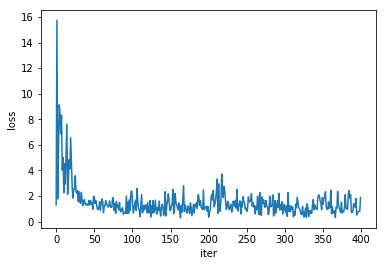

In [23]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("loss")
plt.show()

**Evaluate performance**

Evaluation...


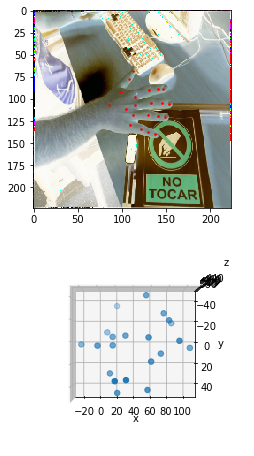

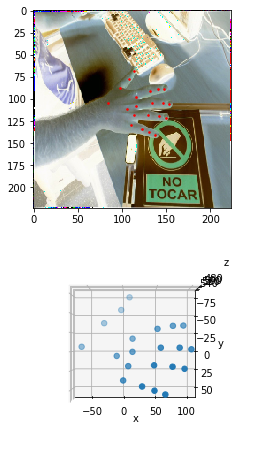

In [24]:
def makePosList(h_pred, l_pred):
    p2d_y, p2d_x = np.unravel_index(torch.argmax(h_pred.view(num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    p3d_x = l_pred[0].data.numpy()
    p3d_x = p3d_x[p2d_y, p2d_x]

    p3d_y = l_pred[1].data.numpy()
    p3d_y = p3d_y[p2d_y, p2d_x]

    p3d_z = l_pred[2].data.numpy()
    p3d_z = p3d_z[p2d_y, p2d_x]

    p3d = np.stack((p3d_x, p3d_y, p3d_z), axis=-1)
    
    return p2d, p3d

print("Evaluation...")
eval_loss = 0
eval_iter = 0
for idx, batch in enumerate(loader_train):
    eval_iter = idx
    image = batch['image'].float()
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    y_pred = model(image)
    h_pred = modelHeatmap(y_pred)
    l_pred = modelLocmap(y_pred)
    #print("output shape: {}".format(y_pred.shape))
    # use heatmap loss defined in VNect
    #loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
    
    #eval_loss = eval_loss + loss
    
    if idx == 0:
        # show some images
        p2d, p3d = makePosList(h_pred[0], l_pred[0])
        show_joints(image[0].data.numpy().transpose((1,2,0)), p2d, p3d)
        show_joints(image[0].data.numpy().transpose((1,2,0)), batch['pos_2d'][0], batch['pos_3d'][0])
        break

#eval_iter = eval_iter + 1
#print("Eval Loss: {}".format(eval_loss / eval_iter))

**Save and load trained models**

In [245]:
#torch.save(model, 'model.pt')
#model = torch.load('model.pt')

# save/load only the model parameters(prefered solution)
torch.save(model.state_dict(), 'model_param.pt')
#model.load_state_dict(torch.load('model_param.pt'))